# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Constants

In [2]:
IMG_SIZE = (256, 256)    # Dataset images size
BATCH_SIZE = 32          # No. of images to feed model at each step
CHANNELS = 3             # No. of channels in image
EPOCHS = 20              # No. of training iterations on dataset
TRAIN_SIZE = 0.8         # Ratio of train set from whole dataset
VAL_SIZE = 0.1           # Ratio of validation set from train set
MODEL_INPUT_SHAPE = (BATCH_SIZE, *IMG_SIZE, CHANNELS)

# Reading data

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../Dataset',              # Path to directory
    shuffle=True,           # Randomize images
    image_size=IMG_SIZE,    # Input image size
    batch_size=BATCH_SIZE   # Divide whole dataset into mini batches for fast training
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print('Classes in our dataset: ', class_names)

Classes in our dataset:  ['Early_blight', 'Late_blight', 'healthy']


In [5]:
# Randomly shuffling dataset
dataset = dataset.shuffle(10000, seed=12)

# Ploting leaves images

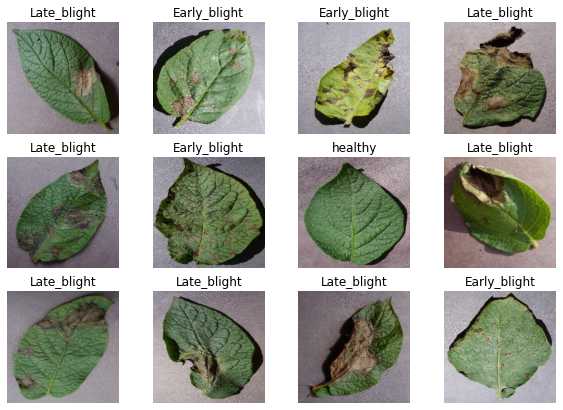

In [6]:
plt.figure(figsize=(10, 7))
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
train_size = int(len(dataset)*TRAIN_SIZE)
val_size = int(len(dataset)*VAL_SIZE)

train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).skip(val_size)
val_set = dataset.skip(train_size).take(val_size)

## Prefetching

In [8]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model building

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(*IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape = (BATCH_SIZE, *IMG_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

In [12]:
model.build(input_shape)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

# Training

In [14]:
training_history = model.fit(
    train_set,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_set,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
)

Epoch 1/20
54/54 [==============================] - 171s 3s/step - loss: 0.9309 - accuracy: 0.4736 - val_loss: 0.8898 - val_accuracy: 0.5729
Epoch 2/20
54/54 [==============================] - 170s 3s/step - loss: 0.7543 - accuracy: 0.6549 - val_loss: 0.5786 - val_accuracy: 0.7552
Epoch 3/20
54/54 [==============================] - 172s 3s/step - loss: 0.5107 - accuracy: 0.7887 - val_loss: 0.6899 - val_accuracy: 0.6771
Epoch 4/20
54/54 [==============================] - 171s 3s/step - loss: 0.3092 - accuracy: 0.8750 - val_loss: 0.4504 - val_accuracy: 0.8542
Epoch 5/20
54/54 [==============================] - 172s 3s/step - loss: 0.3024 - accuracy: 0.8715 - val_loss: 0.2708 - val_accuracy: 0.9062
Epoch 6/20
54/54 [==============================] - 170s 3s/step - loss: 0.1838 - accuracy: 0.9290 - val_loss: 0.5814 - val_accuracy: 0.7500
Epoch 7/20
54/54 [==============================] - 135s 2s/step - loss: 0.1425 - accuracy: 0.9413 - val_loss: 0.2547 - val_accuracy: 0.9219
Epoch 8/20
54

# Accuracy during accuracy
Below in the graph you can see there are four lines.
 - **Loss**: Loss of model after every epoch (in test set)
 - **Accuray**: Accuracy of model after each epoch (in test set)
 - **Validation loss**: Loss of model for validation set
 - **Validation accuracy**: Accuracy of model for validation set

By viewing the trend of these matrices you can decide when to how much epochs you need

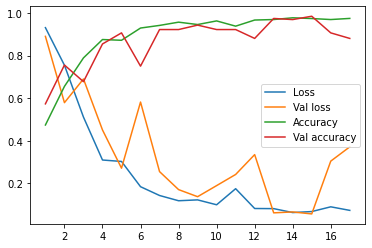

In [16]:
x = range(1, len(training_history.history['loss'])+1)
plt.plot(x, training_history.history['loss'], label='Loss')
plt.plot(x, training_history.history['val_loss'], label='Val loss')
plt.plot(x, training_history.history['accuracy'], label='Accuracy')
plt.plot(x, training_history.history['val_accuracy'], label='Val accuracy')
plt.legend()

# Saving the model
We'll save the model so that we can you it else where.

`tensorflow.keras.model.save(filepath)` is a method by which we can save our model to disk.

In [17]:
model.save('../models/adlskf.h5')

# Tesing
We'll now evaluate our model using `tensorflow.keras.model.evaluate()` to see its accuracy on test data.

In [18]:
loss, accuracy = model.evaluate(test_set, verbose=0)
print(f'Accuracy : {accuracy}\nLoss     : {loss}')

Accuracy : 0.8828125
Loss     : 0.3306190073490143


In [19]:
def make_prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

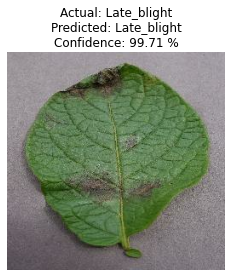

In [20]:
for images, labels in test_set.take(1):
    predicted_class, confidence = make_prediction(model, images[0].numpy())
    actual_class = class_names[labels[0]]
    
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence} %')
    plt.axis('off')